In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def bacon_watts_method(time, capacity):
    """
    Detect the turning point (knee point) in the capacity curve using the Bacon-Watts method.
    
    Parameters:
    - time: Original time data (e.g., cycle number)
    - capacity: Original capacity data

    Returns:
    - best_split_index: Index of the knee point in the data
    - jump_point_time: Original time value corresponding to the knee point
    - jump_point_capacity: Original capacity value corresponding to the knee point
    """
    n = len(time)
    best_split_index = 0
    min_total_error = float('inf')

    # Traverse all possible split points
    for split in range(1, n - 1):
        # Split the data into left and right segments
        time_left, capacity_left = time[:split], capacity[:split]
        time_right, capacity_right = time[split:], capacity[split:]
        
        # Fit linear models to the left and right segments
        model_left = LinearRegression().fit(time_left.reshape(-1, 1), capacity_left)
        model_right = LinearRegression().fit(time_right.reshape(-1, 1), capacity_right)
        
        # Calculate prediction errors for both segments
        predicted_left = model_left.predict(time_left.reshape(-1, 1))
        predicted_right = model_right.predict(time_right.reshape(-1, 1))
        error_left = np.sum((capacity_left - predicted_left) ** 2)
        error_right = np.sum((capacity_right - predicted_right) ** 2)
        
        # Compute total error
        total_error = error_left + error_right

        # Update best split point if current split yields a smaller error
        if total_error < min_total_error:
            min_total_error = total_error
            best_split_index = split

    # Retrieve the original values at the knee point
    jump_point_time = time[best_split_index]
    jump_point_capacity = capacity[best_split_index]

    return best_split_index, jump_point_time, jump_point_capacity


In [2]:
import os
import time
import pickle
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy import interpolate
from datetime import datetime
import pandas as pd
from tool import EarlyStopping
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error, r2_score
from net import CRNN
from common1 import *
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Conv1d
from kneed import KneeLocator
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler, TensorDataset
from torch.utils.data.sampler import RandomSampler
import scipy
import copy
import itertools
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

pkl_list = os.listdir('./data/wx_tp_data/')
tot_name = copy.deepcopy(pkl_list)
file_dir = './data/wx_tp_data/'
tot_cap, tot_tp, tot_eol = [], [], []
for name in pkl_list:
    Battery = pd.read_excel(file_dir + name)
    tmp_cap = Battery['Capacity (Ah)'].tolist()[11:]

    ind_eol = np.where(np.array(tmp_cap) < 0.8)[0][0]    
    tot_eol.append(ind_eol)
    tot_cap.append(tmp_cap[:ind_eol])
    
    capacity = np.array(tot_cap[-1])  
    time = np.array([x for x in range(len(capacity))])

    best_split_index, jump_point_time, jump_point_capacity = bacon_watts_method(time, capacity)
    tot_tp.append(jump_point_time)

     

平均 R²: 0.98848148849877
平均 RMSE: 0.010274128318806806
平均 MAPE (%): 18.051437491337573


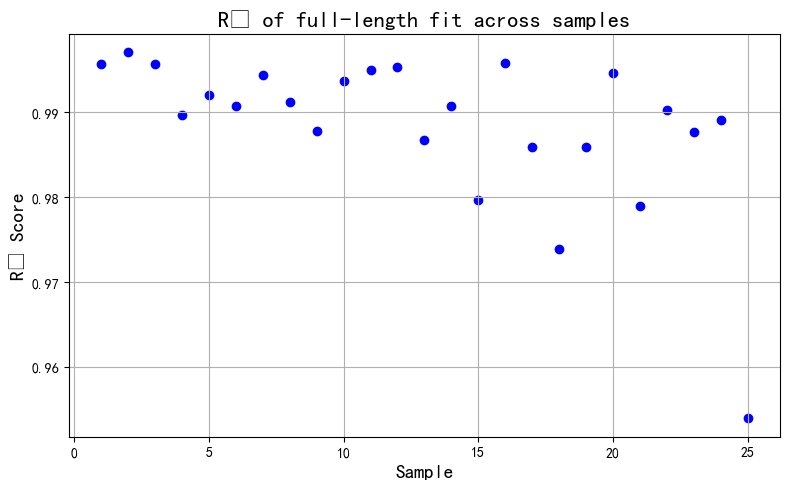

In [3]:
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

def func(x, D1, D2):
    return D1 * np.sqrt(x) + D2 * np.power(x, 1.5)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-6, y_true)  # 避免除0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 结果容器
tot_r2 = []
tot_rmse = []
tot_mape = []

tot_jl = []
tot_Tcap = []

for num in range(len(tot_cap)):
    # 生命周期区间
    Cycle = np.arange(tot_eol[num])
    
    # 平滑容量 + 损失计算
    cap_tmp = savgol_filter(tot_cap[num][:tot_eol[num]], 20, 4)
    Qloss = tot_cap[num][0] - cap_tmp

    # 拟合整个区间
    popt, _ = curve_fit(func, Cycle, Qloss)
    
    # 预测全周期
    Qloss_pred = func(Cycle, *popt)

    # 存储拟合曲线和真实曲线
    tot_jl.append(Qloss_pred)
    tot_Tcap.append(Qloss)

    # 全周期评估
    tot_r2.append(r2_score(Qloss, Qloss_pred))
    tot_rmse.append(rmse(Qloss, Qloss_pred))
    tot_mape.append(mape(Qloss, Qloss_pred))

# 平均指标输出
print("平均 R²:", np.mean(tot_r2))
print("平均 RMSE:", np.mean(tot_rmse))
print("平均 MAPE (%):", np.mean(tot_mape))

# 可视化 R²
x = np.arange(1, len(tot_cap) + 1)
plt.figure(figsize=(8, 5))
plt.scatter(x, tot_r2, color='blue', label='R²')
plt.xlabel('Sample', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.title('R² of full-length fit across samples', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Define the nonlinear model y = A * sqrt(x) + B * x^1.5
def model(A, B, x):
    return A * np.sqrt(x) + B * np.power(x, 1.5)


# Recursive Least Squares with regularization and soft constraint
class RecursiveLeastSquares:
    def __init__(self, lambda_factor=0.99, delta=1e3, regularization_factor=0.1):
        # Initialize RLS parameters
        self.lambda_factor = lambda_factor  # Forgetting factor
        self.regularization_factor = regularization_factor  # Regularization strength
        self.theta = np.array([1e-1, 0], dtype=np.float64)  # Initial parameters [A, B]
        self.P = np.eye(2, dtype=np.float64) * delta  # Initial covariance matrix

    def update(self, x, y):
        # Feature vector φ_t = [sqrt(x), x^1.5]
        phi_t = np.array([np.sqrt(x), np.power(x, 1.5)], dtype=np.float64)

        # Gain matrix K_t
        P_phi = self.P @ phi_t
        gain = P_phi / (self.lambda_factor + phi_t.T @ P_phi)

        # Update parameters θ_t
        self.theta += gain * (y - phi_t.T @ self.theta)

        # Soft constraint on A to prevent negativity
        if self.theta[0] < 0:
            self.theta[0] += self.regularization_factor * abs(self.theta[0]) * 4
            if self.theta[0] < 0:
                self.theta[0] = 0

        # Update covariance matrix P_t
        self.P = (self.P - np.outer(gain, phi_t.T @ self.P)) / self.lambda_factor

    def get_params(self):
        return self.theta  # Return [A, B]


# Batch initialization
def batch_initialize(x_data, y_data, rls, batch_size):
    for i in range(batch_size):
        rls.update(x_data[i], y_data[i])


# Global experiment parameters
window_size = 30  # Rolling window size
increase_length = 24
threshold = 8

# Split the temporary dataset into validation and test sets
valid_tot_cap, test_tot_cap, valid_tot_eol, test_tot_eol, valid_tot_tp, test_tot_tp = train_test_split(
    tot_cap, tot_eol, tot_tp, test_size=0.6, random_state=42
)

tot_cap_data = test_tot_cap
tot_tp_data = test_tot_tp
tot_eol_data = test_tot_eol
threshold = threshold * 1e-6
tot_tp_pre = []

# Run experiment on each sample
for num in range(len(tot_cap_data)):
    Cycle = [x for x in range(5000)]
    Qloss = max(tot_cap_data[num]) - np.array(tot_cap_data[num])
    y_data = Qloss[:tot_eol_data[num]]
    # y_data = scipy.signal.savgol_filter(y_data, 50, 4)
    x_data = np.array(Cycle[:tot_eol_data[num]]) / 5000
    cyc = Cycle[:tot_eol_data[num]]

    # Initialize RLS
    rls = RecursiveLeastSquares(lambda_factor=0.98, delta=1e3)

    # Batch initialize
    batch_initialize(x_data, y_data, rls, batch_size=10)

    # Save history of parameter updates
    A_history = []
    B_history = []
    r2_history = []
    fitted_capacity_history = []

    # Recursive update for each point
    for t, (x, y) in enumerate(zip(x_data, y_data)):
        rls.update(x, y)
        A, B = rls.get_params()

        A_history.append(A)
        B_history.append(B)

        y_fit_current = model(A, B, x_data[:t + 1])
        r2_value = r2_score(y_data[:t + 1], y_fit_current)
        r2_history.append(r2_value)

        fitted_capacity_history.append(y_fit_current[-1])  # Save the last fitted value

    t = np.arange(0, len(A_history))
    series = pd.Series(A_history)

    # Compute rolling variance
    variance_signal = series.rolling(window=window_size).var()
    moving_avg = np.convolve(variance_signal, np.ones(window_size) / window_size, mode='valid')
    padding = np.full(window_size - 1, np.nan)
    variance_signal = np.concatenate((padding, moving_avg))

    increasing_start_idx = None
    increase_count = 0

    # Detect the starting point of a consistently increasing trend
    for idx in range(50, len(variance_signal)):
        if variance_signal[idx] > variance_signal[idx - 1] and variance_signal[idx] > threshold:
            increase_count += 1
            if increase_count >= increase_length:
                increasing_start_idx = idx - increase_length + 1
                break
        else:
            increase_count = 0  # Reset counter

    # Ensure index is within bounds
    if increasing_start_idx is not None:
        increasing_start_time = increasing_start_idx
    else:
        increasing_start_time = len(A_history)

    tot_tp_pre.append(increasing_start_time)


# Evaluate prediction results
prd_er = np.array(tot_tp_data) - np.array(tot_tp_pre)
pos_prd_er = []
pos_tp = []
pos_pr = []
true_positive = []
all_prediction_advance_times = []  # Store all prediction lead times

for i in range(len(prd_er)):
    if tot_tp_pre[i] is not None:  # Exclude None values
        time_diff = prd_er[i]  # Prediction lead time
        if time_diff >= 0:
            pos_pr.append(tot_tp_pre[i])
            pos_prd_er.append(time_diff)

        # True positive if within 20% of the actual knee point
        if 0 < time_diff <= tot_eol_data[i] * 0.2:
            true_positive.append(tot_tp_pre[i])

# Calculate evaluation metrics
tp = len(true_positive)
fp = len(pos_pr) - len(true_positive)
tn = 0
fn = len(tot_tp_data) - len(pos_pr)

precision = tp / (tp + fp) if tp + fp != 0 else 0
recall = tp / (tp + fn) if tp + fn != 0 else 0
specificity = tn / (tn + fp) if tn + fp != 0 else 0
f1_score_value = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

mean_prediction_advance_time = np.mean(pos_prd_er) if len(pos_prd_er) > 0 else 0
detection_success_rate = len(pos_prd_er) / len(tot_tp_data)

print(f"Detection success rate: {detection_success_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Mean prediction advance time (cycles): {mean_prediction_advance_time:.1f}")

Detection success rate: 0.8667
Precision: 1.0000
Mean prediction advance time (cycles): 74.3


In [4]:
import pandas as pd

# Add labels based on prediction performance
labels = []
for i in range(len(tot_tp_data)):
    if prd_er[i] >= 0:
        if tot_tp_pre[i] in true_positive:
            labels.append("Effective warning")
        else:
            labels.append("Ineffective warning")
    else:
        labels.append("Failed warning")

# Create a DataFrame with prediction results
df_results = pd.DataFrame({
    'Warning time': tot_tp_pre,
    'Knee time': tot_tp_data,
    'Label': labels
})

# Count the number of each warning type
effective_count = labels.count("Effective warning")
ineffective_count = labels.count("Ineffective warning")
failed_count = labels.count("Failed warning")

# Print the statistics
print(f"Effective warning count: {effective_count}")
print(f"Ineffective warning count: {ineffective_count}")
print(f"Failed warning count: {failed_count}")


Effective warning count: 13
Ineffective warning count: 0
Failed warning count: 2
